
# __Projet numérique:__ Lignes de niveau
---


## Contour simple

On fixe $x = 0$. On peut donc se ramener à une fonction de la variable réelle $g:y \to f(0,y) $ 

g étant continue, on utilise la conclusion du `Théorème des valeurs intermediaires` pour poser comme condition raisonnable
$ (f(0,1) -c) * (f(0,0) - c) < 0 $
ie $ c \in g([0,1])$

Soit $ \varepsilon > 0 $                
Assurés de l'existence de $t_{0}$ tel que $ f(0,t_{0}) = c $, on souhaite trouver $ t, |t-t_{0}|< \varepsilon $ Pour trouver un tel t, on va utiliser la méthode des secantes (on suppose g suffisamment régulière pour ne pas sortir de l'intervalle )

Soient $y_{0}, y_{1}$ deux points dans un voisinage de $t_{0}$,
on construit alors une suite de points que l'on espère convergente vers $t_{0}$, telle que:   

$\forall n \in \mathbb{N}, y$<sub>$n+2$</sub> $= y$<sub>$n$</sub>$ \ -\  f(y$<sub>$n$</sub>$) * \frac{(y_{n+1} - y_{n})}{f(y_{n+1}) - f(y_{n})} $
   

In [89]:
import math as m
import itertools as iter
import autograd 
from autograd import numpy as np
import matplotlib.pyplot as plt

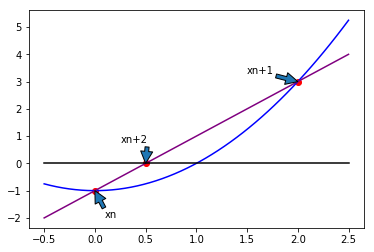

In [90]:
#Illustration de la méthode des sécantes:

f = np.vectorize(lambda x : x ** 2 -1)
#secante en xo = 0 et x1 = 2
g = np.vectorize(lambda x : ((f(2) - f(0)) / ( 2 - 0)) * (x - 0) + f(0))

#graphe:
x = np.linspace(-0.5,2.5)
y = f(x)
z = g(x)
a = np.zeros(len(x))

plt.plot(x,y, label = 'f(x)', color = 'blue')
plt.plot(x,z, label = 'g(x)', color = 'purple')
plt.plot(x,a, color = 'black')
plt.scatter([0.5, 0, 2], [0, -1, 3], color = 'red')


plt.annotate('xn+2', xy=(0.5, 0), xytext=(0.25, 0.75), arrowprops=dict())
plt.annotate('xn', xy=(0, -1), xytext=(0.1, -2), arrowprops=dict())
plt.annotate('xn+1', xy=(2, 3), xytext=(1.5, 3.3), arrowprops=dict())

plt.show()



> **Définition de *find_seed* **  
        Specification $ : fonction \to float \to float \to float $

In [91]:
def find_seed(f, c = 0, eps = 2**(-26)):
    #methode des sécantes
    g = lambda y : f(0,y)
    
    if (c -g(0)) * (c -g(1)) > 0:
        return None
    
    elif (c -g(0)) * (c -g(1)) == 0:
        return 1. * ((c -g(1)) == 0)
    
    else:
        a , b = 0, 1
        while abs(b - a) > eps: 
        #ne serait-il pas judicieux de tester aussi une condition sur (g(b) -c)?
            a, b = b, a - (b - a) / (g(b) - g(a)) * g(a)
        return b

## Propagation

On commence par définir quelques fonctions auxiliaires qui nous serviront par la suite:

In [92]:
#fonction renvoyant le gradient de la fonction passée en parametre
def grad(f):
    def gradient_f(x,y):
        g = autograd.grad
        return np.r_[g(f, 0)(x,y), g(f, 1)(x,y)]
    return gradient_f



__Idée:__  
    Soit $X$ une ligne de niveau de $f$,   
    ie $X = f^{-1} (\{c\}) = \{(x,y), f(x,y) = c\} $
    
Soit $ a = (x_{0}, y_{0}) \in X $ , $v$ tangent à $X$ en $a$,  
Il existe $\gamma : [0,1] \to X $ un chemin $C^1$ verifiant:  
    $\forall t \in [0,1], \gamma(t) \in X$    
    $\gamma(0) = a$  
    $\gamma ^{'}(0) = v $

alors $h : t \to f(\gamma(t))$ est constante sur $[0,1]$,  
donc $d(h) = 0$ ie $ \forall t \in [0,1] ,  grad(f(\gamma(t)).\gamma^{'}(t) = 0  $  
donc $grad(f(\gamma(0)).\gamma^{'}(0) = 0  $ ie $grad(f(a).v = 0 $   
ie l'ensemble des vecteurs tangents à $X$ en $a$ est inclu dans l'ensemble des vecteurs orthogonaux au gradient de $f$ en $a$



                                                                        
                                                                        
    

__Idée d'implementation : __  
  1. On commence par chercher une amorce sur l'arête gauche  
  2. Puis on suit la normale au gradient:   
       contraintes :   
> Ne pas sortir du domaine de definition de f  
> Ne pas faire demi-tour: on stocke le mouvement effectué précedemment $v$. Une fois que l'on dispose de la tangente $u$ à la ligne de niveau, on calcule le produit  scalaire $\langle u,v\rangle$. On souhaite avoir un angle aigu entre la direction que l'on va suivre et le vecteur mouvement précedent, ie  $ \ \langle u,v\rangle \ \ge \ 0$



On va utiliser le module autograd pour calculer le gradient de f, comme defini plus haut

On definit une fonction *__suivant__* qui à partir d'un point d'une ligne de niveau renvoie le point suivant, distant d'environ $\delta$, ainsi que le vecteur directeur du mouvement effectué. Cette fonction corrige l'erreur dûe à l'approximation linéaire de $f$ effectuée.

In [93]:
def suivant(f, delta, position, ancien_mouv):
    g = grad(f)
    
    gradient_fpos = g(position[0], position[1])
 
    if np.vdot(gradient_fpos - (0.,0.), gradient_fpos - (0.,0.) ) < 10**(-16):
    #gradient nul -> on ne sait plus où aller? autre solution: faire un pas de plus?
        return [],[]
        
    else: 
        tangent = np.array([- gradient_fpos[1], gradient_fpos [0]]) #vecteur tangent à la ligne de niveau est normal au gradient
    
        angle = np.vdot(tangent, ancien_mouv)
    #condition de non demi-tour:
        if angle < 0: 
            tangent = -tangent
            
        prochain = position + delta * tangent / m.sqrt(np.vdot(tangent, tangent))
        
    #correction de l'erreur dûe à l'approximation lineaire:
        while abs(f(prochain[0], prochain[1])) > 2**(-26): 
            gradient_fproch = g(prochain[0], prochain[1])
            #df = dy/dx --> dx = dy/df
            if f(prochain[0], prochain[1]) > 0: 
                prochain = prochain - abs(f(prochain[0], prochain[1])) * gradient_fproch / (np.vdot(gradient_fproch, gradient_fproch)) #norme au carré
            else:
                prochain = prochain + abs(f(prochain[0], prochain[1])) * gradient_fproch / (np.vdot(gradient_fproch, gradient_fproch))
        
        
    #On verifie qu'on est toujours dans le domaine de def:
        if prochain[0] > 1 or prochain[1] > 1 or prochain[0] < 0 or prochain[1] < 0:
             
            #cas particulier de l'initialisation
            if (ancien_mouv[0], ancien_mouv[1]) == (0.,0.):
                prochain = position - delta * tangent / m.sqrt(np.vdot(tangent, tangent))
                
                return prochain, (prochain-position)
                
            #sinon on s'arrête:
            return [],[]
    
        else:
            return prochain , (prochain-position) #on renvoie le prochain point et le vecteur mouvement

**Probleme:** propagation des erreurs dûes à l'approximation lineaire: 
1. Idée 1: Méthode de Newton
2. Idée 2: on regarde si on est superieur ou inferieur à $c = 0$ et on suit le gradient de f en le point $z \in \mathbb{R} ^{2} $ où l'on se trouve dans le bon sens (gradient orienté dans le sens des $f(x,y)$ croissants)

Approximation __1D__ : $\Delta f = \frac{\Delta y}{\Delta x} $ donc $\Delta x \sim \frac{\Delta y}{\Delta f}$   
On se décale donc de $ \delta \vec r = f(z) * \frac{\vec{grad(f)}(z)}{||\vec {grad(f)}(z)|| ^{2}} $

> **Définition de *simple_contour* **  
        Specification $ : fonction \to float \to float \to array * array $

In [94]:
def simple_contour(fun, c = 0.0, delta = 0.01):
    #On se ramène au cas c = 0    
    def f(x,y):
        return fun(x,y) - c
    
    # trouver une amorce
    amorce = find_seed(f, 0)
    if not (amorce == None):
        prochain = (0.,amorce)
    else:
        prochain = []
        
    ancien_mouv = (0.,0.)
    fragment = []
    i = 0
    
    # tant qu'on peut trouver un suivant on continue d'avancer
    while not (prochain == []) and i<1200:
        fragment.append(prochain)
        prochain, ancien_mouv = suivant(f, delta, prochain, ancien_mouv)
        i +=1
    if fragment == []:
        return [], []
    else:
        return [a[0] for a in fragment], [a[1] for a in fragment]

On verifie que notre fonction est correcte et termine en l'appliquant à $f : x,y \in [0,1]^{2} \to x^2 +y^2 $
On commence par tester sans la correction d'erreur, puis on verifie que ladite correction fait bien son travail.

In [95]:
#On utilise une version de suivant qui ne corrige pas l'erreur
#On a aussi supprimé la condition sur le domaine pour plus de visibilité

def suivant_sanscorrection(f, delta, position, ancien_mouv):
    g = grad(f)
    gradient_fpos = g(position[0], position[1])
    if np.vdot(gradient_fpos - (0.,0.), gradient_fpos - (0.,0.) ) < 10**(-16):
        return [],[]
    else: 
        tangent = np.array([- gradient_fpos[1], gradient_fpos [0]])
        angle = np.vdot(tangent, ancien_mouv)
        if angle < 0:
            tangent = -tangent
        prochain = position + delta * tangent / m.sqrt(np.vdot(tangent, tangent))
        return prochain , (prochain-position)
    

def simple_contour_sanscorrection(fun, c = 0.0, delta = 0.01):
    def f(x,y):
        return fun(x,y) - c
    amorce = find_seed(f, 0)
    if not (amorce == None):
        prochain = (0.,amorce)
    else:
        prochain = []
    ancien_mouv = (0.,0.)
    fragment = []
    i = 0
    while not (prochain == []) and i<1200:
        fragment.append(prochain)
        prochain, ancien_mouv = suivant_sanscorrection(f, delta, prochain, ancien_mouv)
        i +=1
    if fragment == []:
        return [], []
    else:
        return [a[0] for a in fragment], [a[1] for a in fragment]
    
    
    
def suivant_sansdomaine(f, delta, position, ancien_mouv):
    g = grad(f)
    gradient_fpos = g(position[0], position[1])
    if np.vdot(gradient_fpos - (0.,0.), gradient_fpos - (0.,0.) ) < 10**(-16):
        return [],[]  
    else: 
        tangent = np.array([- gradient_fpos[1], gradient_fpos [0]])
        angle = np.vdot(tangent, ancien_mouv)
        if angle < 0:
            tangent = -tangent 
        prochain = position + delta * tangent / m.sqrt(np.vdot(tangent, tangent))      
        while abs(f(prochain[0], prochain[1])) > 2**(-26):
            gradient_fproch = g(prochain[0], prochain[1])
            if f(prochain[0], prochain[1]) > 0:
                prochain = prochain - abs(f(prochain[0], prochain[1])) * gradient_fproch / (np.vdot(gradient_fproch, gradient_fproch)) #norme au carré
            else:
                prochain = prochain + abs(f(prochain[0], prochain[1])) * gradient_fproch / (np.vdot(gradient_fproch, gradient_fproch))
        return prochain , (prochain-position)
    
def simple_contour_sansdomaine(fun, c = 0.0, delta = 0.01):
    def f(x,y):
        return fun(x,y) - c
    amorce = find_seed(f, 0)
    if not (amorce == None):
        prochain = (0.,amorce)
    else:
        prochain = []
    ancien_mouv = (0.,0.)
    fragment = []
    i = 0
    while not (prochain == []) and i<1200:
        fragment.append(prochain)
        prochain, ancien_mouv = suivant_sansdomaine(f, delta, prochain, ancien_mouv)
        i +=1
    if fragment == []:
        return [], []
    else:
        return [a[0] for a in fragment], [a[1] for a in fragment]
    
def f(x,y):
    return x**2 + y**2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


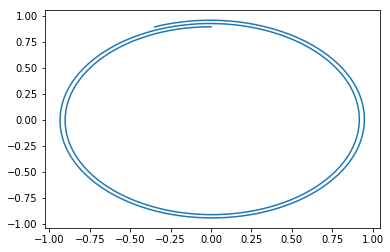

In [96]:
#Resultat sans correction d'erreur
x,y = simple_contour_sanscorrection(f, 0.8)
plt.plot(x,y)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


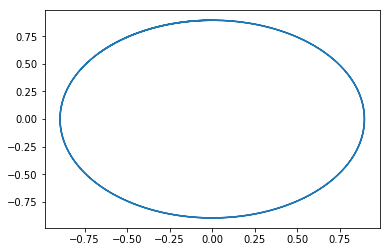

In [97]:
#Resultat avec correction de l'erreur
x,y = simple_contour_sansdomaine(f, 0.8)
plt.plot(x,y)
plt.show()

**On est satisfaits du résultat**

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


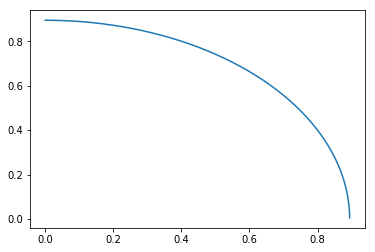

In [98]:
#On appelle la veritable fonction simple_contour:
x,y = simple_contour(f, 0.8)
plt.plot(x,y)
plt.show()

## Contour Complexe

__Idée : __  
On va découper le domaine de définition de $f$ en un quadrillage de pas connu, puis on va appliquer la démarche précedente sur chaque élément de maillage, à la difference près que nous chercherons cette fois ci les amorces sur tout le pourtour du domaine. 

On commence donc par redéfinir *__find_seeds__* de telle sorte que cette fonction renvoie desormais la liste de toutes amorces trouvées, ie les intersections entre la ligne de niveau cherchée et le contour de la case.
Puis on calcule chaque fragment.
- **Remarques: **   
    On risque de calculer plusieurs fois le même fragment   
    On va trouver plusieurs fois les mêmes amorces en appliquant la méthode sur des cases adjacentes, une amelioration possible serait une version mémoïsée.


> **find_seedmodif** 
> Prend en paramètre les coordonnées de la case, et renvoie la liste des amorces trouvées sur le pourtour

Les cotés de la case sont ainsi numérotés:  
`  .
                   _4__
                  |    |
                 1|____|2 
                     3                   `

In [99]:
def find_seedmodif(f, indice_xmin, indice_ymin, xc, yc, c = 0., eps = 2**(-26)):
    i=indice_xmin
    j=indice_ymin
    seeds = []
    l = [lambda y : f(xc[i],y), lambda y : f(xc[i+1],y), lambda x : f(x,yc[j]), lambda x : f(x,yc[j+1])]
    
              #     _4__
               #   |    |
                # 1|    |2
                 #  _3__
                    
    for k in range(4):
        g = l[k]
        if k < 2:
            
            x = xc[i] * (k==0) + xc[i+1] * (k==1)
            if (c -g(yc[j])) * (c -g(yc[j+1])) == 0:
                y =  yc[j]* (c -g(yc[j])) + yc[j+1] * ((c -g(yc[j+1])) == 0)
                seeds.append((x,y))
                
            elif (c -g(yc[j])) * (c -g(yc[j+1])) <0:
                a , b = yc[j], yc[j+1]
                while abs(b - a) > eps: 
                    a, b = b, a - (b - a) / (g(b) - g(a)) * g(a)
                seeds.append((x, b))
                
        else:
            y = yc[j] * (k==2) + yc[j+1] * (k==3)
            if (c -g(xc[i])) * (c -g(xc[i+1])) == 0:
                x =  xc[i]* (c -g(xc[i])) + xc[i+1] * ((c -g(xc[i+1])) == 0)
                seeds.append((x,y))
                
            elif (c -g(xc[i])) * (c -g(xc[i+1])) <0:
                a , b = xc[i], xc[i+1]
                while abs(b - a) > eps: 
                    a, b = b, a - (b - a) / (g(b) - g(a)) * g(a)
                seeds.append((b, y))
                
    return seeds

> *__suivant_complexe__* Des modifications minimes apportées à la partie domaine de définition

__Remarque :__ On aurait pu concevoir des fonctions plus modulaires dès le début pour éviter d'avoir à tout redéfinir. En réalité les fonctions *_complexe* sont des généralisations de la première partie.

In [100]:
def suivant_complexe(f, xc, yc, delta, position, ancien_mouv, indice_xmin, indice_ymin):
    xmin = xc[indice_xmin]
    xmax = xc[indice_xmin +1]
    ymin = yc[indice_ymin]
    ymax = yc[indice_ymin +1]
    g = grad(f)
    
    gradient_fpos = g(position[0], position[1])
 
    if np.vdot(gradient_fpos - (0.,0.), gradient_fpos - (0.,0.) ) < 10**(-16):
        return [],[]
        
    else: 
    #vecteur tangent à la ligne de niveau est normal au gradient
        tangent = np.array([- gradient_fpos[1], gradient_fpos [0]])
        angle = np.vdot(tangent, ancien_mouv)
        
        if angle < 0:
            tangent = -tangent
            
        prochain = position + delta * tangent / m.sqrt(np.vdot(tangent, tangent))
        
    # correction des erreurs approximation lineaire:      
        while abs(f(prochain[0], prochain[1])) > 2**(-26):
            gradient_fproch = g(prochain[0], prochain[1])
            if f(prochain[0], prochain[1]) > 0:
                
                prochain = prochain - abs(f(prochain[0], prochain[1])) * gradient_fproch / (np.vdot(gradient_fproch, gradient_fproch)) #norme au carré
            else:
                prochain = prochain + abs(f(prochain[0], prochain[1])) * gradient_fproch / (np.vdot(gradient_fproch, gradient_fproch))
        
    #On verifie qu'on est toujours dans le domaine de def
        if prochain[0] > xmax or prochain[1] > ymax or prochain[0] < xmin or prochain[1] < ymin:
             
            #cas particulier de l'initialisation
            if (ancien_mouv[0], ancien_mouv[1]) == (0.,0.):
                prochain = position - delta * tangent / m.sqrt(np.vdot(tangent, tangent))
                
                return prochain, (prochain-position)
                
            #sinon on s'arrête:
            return [],[]
    
        else:
            return prochain , (prochain-position)

> **Définition de *simple_contour_case* **  
        Cette fonction joue le rôle de simple_contour mais pour un domaine quelconque  
        Specification $ : fonction \to float \to float \to float \to float \to float \to float \to (array \  array) * (array \  array) $

In [101]:
def simple_contour_case(fun,indice_xmin, indice_ymin, xc, yc, c = 0.0, delta = 0.01):
    fragmentS_x= []
    fragmentS_y= []
    amorces = find_seedmodif(fun, indice_xmin, indice_ymin, xc, yc, c= 0)
    for prochain in amorces:
        ancien_mouv = (0.,0.)
        fragment = []
        
        while not (prochain == []): 
            fragment.append(prochain)
            prochain, ancien_mouv = suivant_complexe(fun, xc, yc, delta, prochain, ancien_mouv, indice_xmin, indice_ymin)
        
        fragmentS_x.append([a[0] for a in fragment])
        fragmentS_y.append([a[1] for a in fragment])
        
    return fragmentS_x, fragmentS_y

> **Définition de *contour* **  
        Cette fonction applique simple_contour_case à chaque case du maillage, et renvoie un couple de listes de listes de points de fragments. Les tableaux 1D $xs$ et $ys$ renvoyés par la fonction contour ne décrivent pas un fragment de contour, mais un ensemble de tels fragments: Les valeurs $ x = xs[i]$ et $y = ys[i]$ représentent un fragment de contour de $f$.  
        Specification $ : fonction \to float \to float \  list \to float \  list \to float \to (float \ array \  array) * (float \ array \  array) $

In [102]:
def contour(fun, c = 0.0, xc = [0.0, 1.0], yc = [0.0, 1.0], delta = 0.01):
    def f(x,y):
        return fun(x,y) - c
    xs = []
    ys = []
    for i in range(len(xc) - 1):
        for j in range(len(yc) -1):
            fragX, fragY = simple_contour_case(f,i, j, xc, yc, c = 0.0, delta = 0.01)
            xs = xs + fragX
            ys = ys + fragY
            
    return xs, ys

On définit aussi une fonction d'affichage:

In [103]:
def affichefragment(xs, ys):
    for x, y in zip(xs, ys):
        plt.plot(x,y)
    plt.show()

On peut enfin verifier que notre fonction est correcte sur l'exemple du sujet:

In [104]:
def h(x,y):
    return np.exp(-x**2 - y**2)
    
def g(x,y):
    return np.exp(-(x-1)**2 - (y-1)**2)

def fonction_sujet(x,y):
    return h(x,y) + h(x,y) - g(x,y)

#Domaine de definition:
X = np.linspace(-2,3)
Y = np.linspace(-1,2)

#fonction test
def test_sujet():
    values_c = [-1.5,-1.,-0.5,0.0, 0.5, 1.0, 1.5]
    xs,ys = [],[]
    for cv in values_c:
        x,y = contour(fonction_sujet, c = cv, xc = X, yc = Y)
        xs = xs + x
        ys = ys + y
    affichefragment(xs, ys)

__Le test:__

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


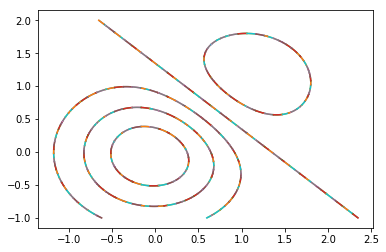

In [105]:
test_sujet()

Ça fonctionne!